# Assignment 2 - Bank Marketing

Link to the data: https://archive.ics.uci.edu/dataset/222/bank+marketing

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

There are four datasets: 
1) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs). 
2) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs). 
3) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
4) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM). 

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y)

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
df_bank = pd.read_csv('Ass2Data\\bank\\bank.csv', delimiter=';')
df_bank_full = pd.read_csv('Ass2Data\\bank\\bank-full.csv', delimiter=';')
df_bank_additional = pd.read_csv('Ass2Data\\bank-additional\\bank-additional\\bank-additional.csv', delimiter=';')
df_bank_additional_full = pd.read_csv('Ass2Data\\bank-additional\\bank-additional\\bank-additional-full.csv', delimiter=';')
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


Comparison between the 4 datasets
- df_bank: 4521 rows, 17 columns
- df_bank_full: 45211 rows, 17 columns

df_bank and df_bank_full have the same columns

- df_bank_additional: 4119 rows, 21 columns.
- df_bank_additional_full: 41188 rows, 21 columns.

Columns that are in the 'additional' datasets but not in the other 2: emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed

# Advanced Exploratory Data Analysis 
Apply techniques from clustering and association rule mining domains.
- Data Cleaning: Outlier detection, summarizing dataset, descriptive stats, visualizations. Distribution of key variables
- AEDA: Scaling, normalization, one hot encoding, pair plots, correlation heatmaps
- Univariate and multivariate
- 2 clustering algorithms and evaluate them
- 2D plots, 3D plots
- association rules mining, evaluate them

## Data cleaning - iris

In [6]:
# Define difference in columns
columns_diff = set(df_bank_additional_full.columns) - set(df_bank_full.columns)
print(columns_diff)

{'nr.employed', 'cons.conf.idx', 'emp.var.rate', 'euribor3m', 'cons.price.idx', 'day_of_week'}


Conclusion:

`df_bank_additional_full` contains the day of the week, and has the social and economic context attributes.

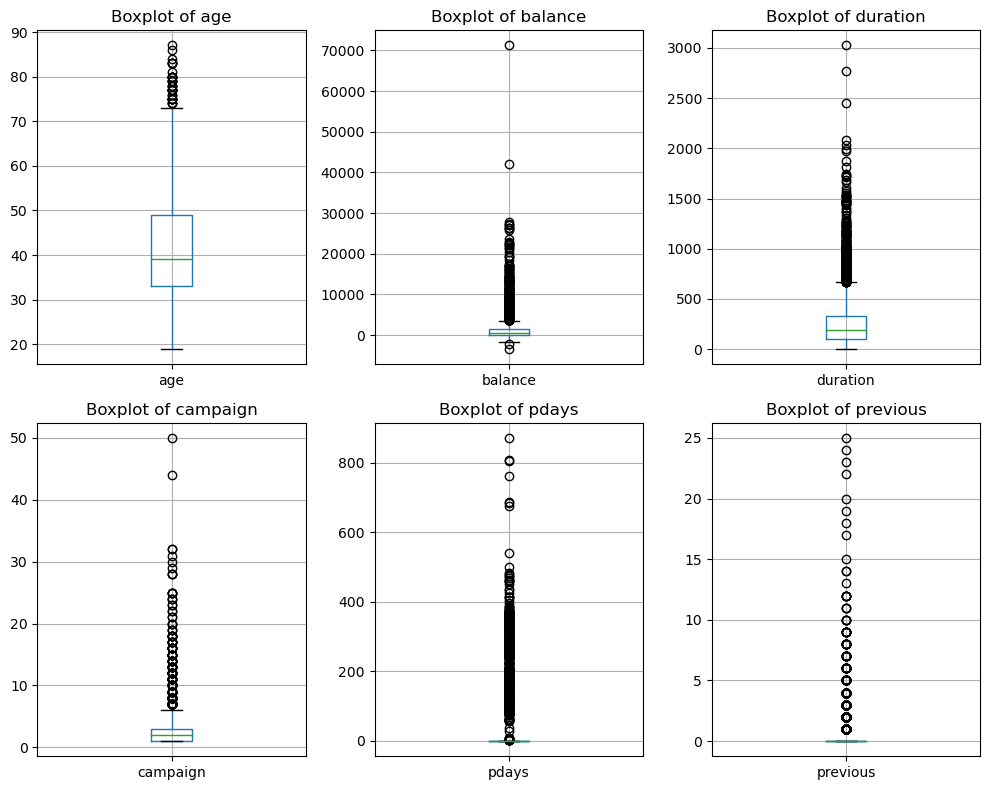

In [31]:
# Outliers
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# List of columns to plot
key_columns = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

# Plot each column in a separate subplot
for i, column in enumerate(key_columns):
    row, col = divmod(i, 3)
    df_bank.boxplot(column=[column], ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [21]:
# Summarizing dataset
summary = df_bank.describe()
print(summary)

               age       balance          day     duration     campaign  \
count  4521.000000   4521.000000  4521.000000  4521.000000  4521.000000   
mean     41.170095   1422.657819    15.915284   263.961292     2.793630   
std      10.576211   3009.638142     8.247667   259.856633     3.109807   
min      19.000000  -3313.000000     1.000000     4.000000     1.000000   
25%      33.000000     69.000000     9.000000   104.000000     1.000000   
50%      39.000000    444.000000    16.000000   185.000000     2.000000   
75%      49.000000   1480.000000    21.000000   329.000000     3.000000   
max      87.000000  71188.000000    31.000000  3025.000000    50.000000   

             pdays     previous  
count  4521.000000  4521.000000  
mean     39.766645     0.542579  
std     100.121124     1.693562  
min      -1.000000     0.000000  
25%      -1.000000     0.000000  
50%      -1.000000     0.000000  
75%      -1.000000     0.000000  
max     871.000000    25.000000  


In [22]:
# Descriptive stats
descriptive_stats = df_bank.describe(include='all')
print(descriptive_stats)

                age         job  marital  education default       balance  \
count   4521.000000        4521     4521       4521    4521   4521.000000   
unique          NaN          12        3          4       2           NaN   
top             NaN  management  married  secondary      no           NaN   
freq            NaN         969     2797       2306    4445           NaN   
mean      41.170095         NaN      NaN        NaN     NaN   1422.657819   
std       10.576211         NaN      NaN        NaN     NaN   3009.638142   
min       19.000000         NaN      NaN        NaN     NaN  -3313.000000   
25%       33.000000         NaN      NaN        NaN     NaN     69.000000   
50%       39.000000         NaN      NaN        NaN     NaN    444.000000   
75%       49.000000         NaN      NaN        NaN     NaN   1480.000000   
max       87.000000         NaN      NaN        NaN     NaN  71188.000000   

       housing  loan   contact          day month     duration     campaign

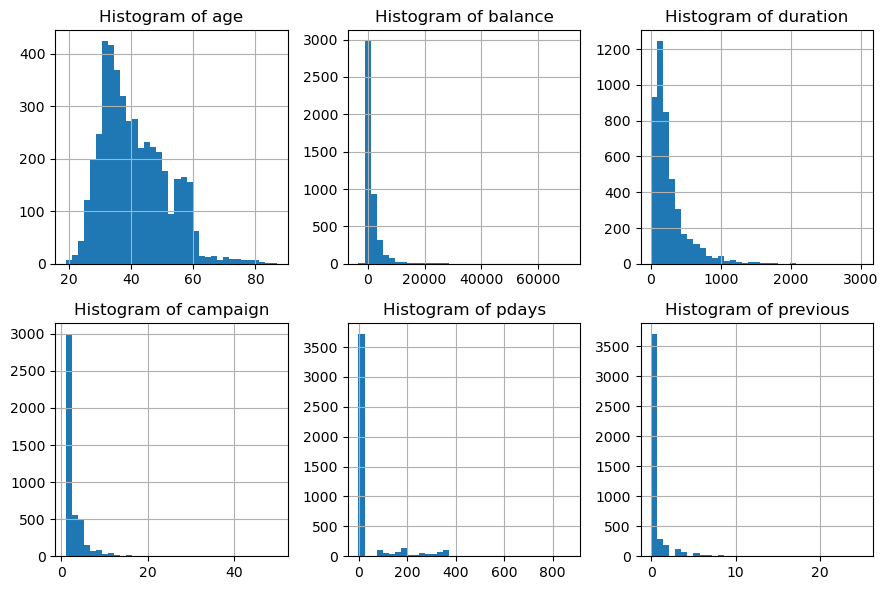

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6))

# Plot each column in a separate subplot
for i, column in enumerate(key_columns):
    row, col = divmod(i, 3)
    df_bank[column].hist(ax=axes[row, col], bins=35)
    axes[row, col].set_title(f'Histogram of {column}')

plt.tight_layout()
plt.show()

All key variables, except age, show a nonnormal distribution. This data should be normalized for furthur analysis.

## Feature engineering - iris

## Clustering
### Cluster algorithm 1 KNN - 

### Cluster algorithm 2  -

## Association rules - Aurelia

# Predictive Modelling


SVM (Kyrie)

XGBoost (Onno)

Random Forest (Mila)

# Comparison between the 3 models